# Report figures notebook

In [2]:
import os

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Title

In [15]:
os.makedirs('report/title', exist_ok=True)

# Dataset overview

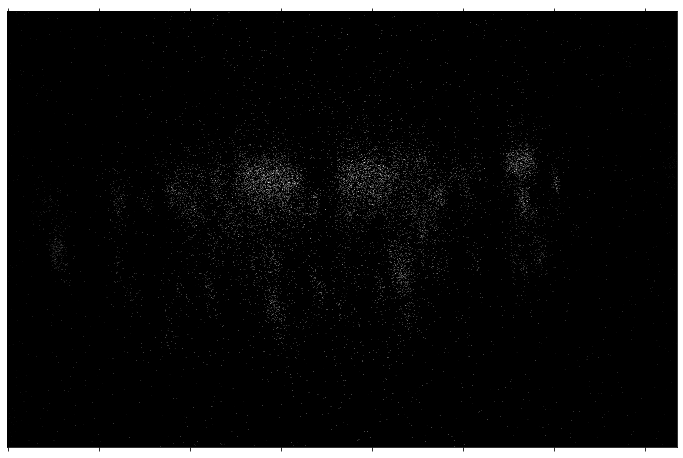

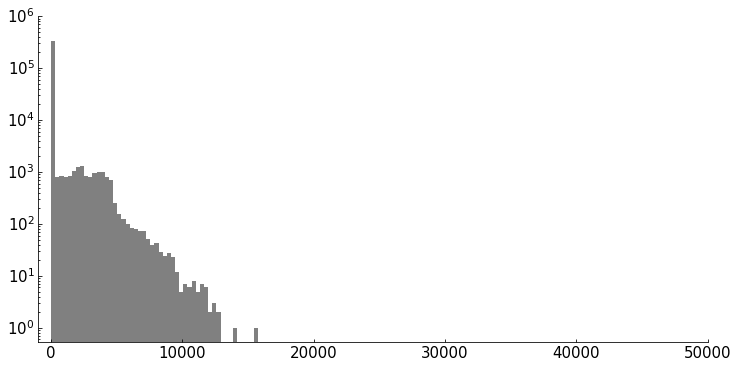

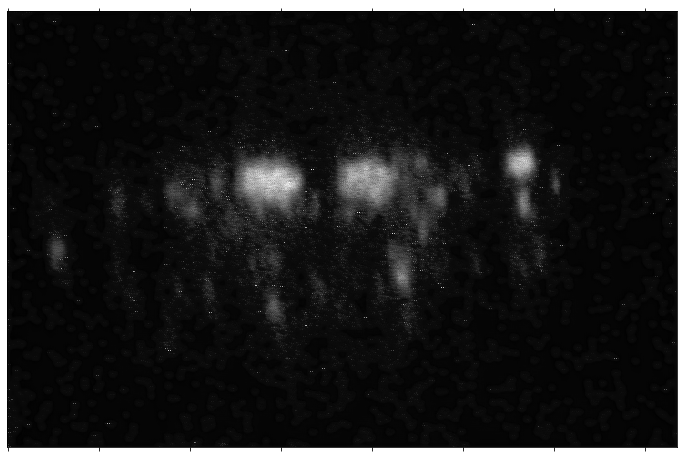

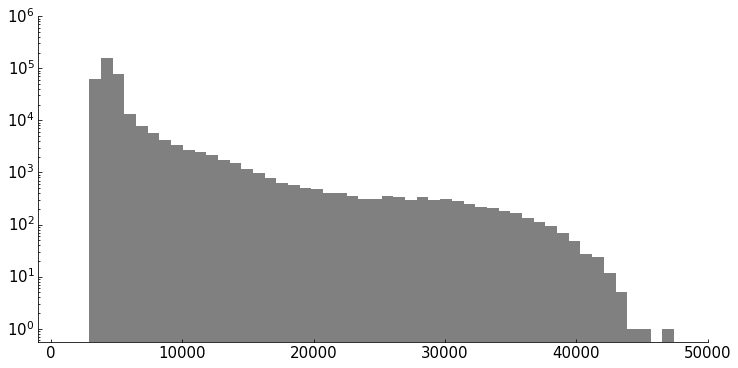

In [37]:
import mpl_toolkits.axisartist as AA
os.makedirs('report/dataset-overview', exist_ok=True)

def plot(path, name):
    img = tiff.imread(path, key=0)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.matshow(img, cmap='gray')

    plt.savefig(f'report/dataset-overview/{name}.svg')
    plt.show()

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1, axes_class=AA.Axes)
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)
    ax.set_yscale('log')
    ax.hist(img.ravel(), bins=50, color='gray')
    ax.set_ylim(None, 1e6)
    ax.set_xlim(-1000, 50_000)

    plt.savefig(f'report/dataset-overview/{name}-hist.svg')
    plt.show()
    

path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/red.tif'
plot(path, 'raw')



path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
plot(path, 'denoised')